In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/sample_submission.csv
/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/train.csv
/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/test.csv


In [2]:

import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import itertools
%matplotlib inline
import plotly
import plotly.express as px
import plotly.graph_objs as go
import math
plt.style.use("seaborn-whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from mlxtend.classifier import StackingCVClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import r2_score, classification_report, confusion_matrix, roc_curve, auc, plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import mutual_info_classif
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from scipy import stats
from scipy.stats import skew
import warnings
warnings.filterwarnings("ignore")

### Data Fields:
`ID` - an ID for this instance.\
Area - `(A)`, The area of a bean zone and the number of pixels within its boundaries.\
Perimeter - `(P)`, Bean circumference is defined as the length of its border.\
MajorAxisLength - `(L)`, The distance between the ends of the longest line that can be drawn from a bean.\
MinorAxisLength - `(I)`, The longest line that can be drawn from the bean while standing perpendicular to the main axis.\
AspectRatio - `(K)`, Defines the relationship between L and l`(L/I)`.\
Eccentricity - `(Ec)`, Eccentricity of the ellipse having the same moments as the region.\
ConvexArea - `(C)`, Number of pixels in the smallest convex polygon that can contain the area of a bean seed.\
EquivDiameter - `(Ed)`, The diameter of a circle having the same area as a bean seed area `sqrt(4*A/pi)`.\
Extent -`(Ex)`, The ratio of the pixels in the bounding box to the bean area.\
Solidity - `(S)`, Also known as convexity. The ratio of the pixels in the convex shell to those found in beans `(A/c)`.\
Roundness - `(R)`, Calculated with the following formula: `(4*pi*A)/(P^2)`.\
Compactness - `(CO)`, Measures the roundness of an object: `(Ed/L)`.\
ShapeFactor1 - `(SF1=L/A)`.\
ShapeFactor2 - `(SF2=I/A)`.\
ShapeFactor3 - `(SF3=A/(pi*L/2*L/2))`.\
ShapeFactor4 - `(SF4=A/(pi*L/2*I/2))`.\
`y` - the class of the bean. It can be any of BARBUNYA, SIRA, HOROZ, DERMASON, CALI, BOMBAY, and SEKER.

# Loading and exploring the dataset

In [3]:
raw_data = pd.read_csv('/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/train.csv')
raw_data

,ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,y
0,0,58238,971.303,397.202654,186.945510,2.124697,0.882317,58977,272.306674,0.604756,0.987470,0.775723,0.685561,0.006820,0.000929,0.469994,0.998595,HOROZ
1,1,44515,757.601,265.590470,213.967453,1.241266,0.592420,44780,238.071960,0.771745,0.994082,0.974620,0.896387,0.005966,0.002376,0.803510,0.997370,SEKER
2,2,31662,653.783,239.902428,168.421505,1.424417,0.712136,32034,200.781748,0.801407,0.988387,0.930853,0.836931,0.007577,0.002293,0.700453,0.997737,DERMASON
3,3,38778,734.020,268.446281,184.061923,1.458456,0.727925,39208,222.201897,0.766137,0.989033,0.904439,0.827733,0.006923,0.002005,0.685142,0.999250,DERMASON
4,4,42530,775.403,281.212824,193.236878,1.455275,0.726511,43028,232.703412,0.729816,0.988426,0.888895,0.827499,0.006612,0.001912,0.684755,0.996507,SIRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10829,10829,37777,716.007,250.174662,192.704033,1.298233,0.637708,38174,219.315230,0.770519,0.989600,0.925983,0.876648,0.006622,0.002413,0.768513,0.997708,SEKER
10830,10830,32187,667.621,247.778775,165.786862,1.494562,0.743179,32582,202.439525,0.731805,0.987877,0.907466,0.817017,0.007698,0.002116,0.667517,0.997646,DERMASON
10831,10831,81837,1095.937,433.838186,241.527026,1.796230,0.830699,82554,322.797312,0.771996,0.991315,0.856226,0.744050,0.005301,0.001002,0.553610,0.994412,CALI
10832,10832,48212,826.362,309.639462,199.285811,1.553746,0.765357,48777,247.760822,0.677002,0.988417,0.887206,0.800159,0.006422,0.001624,0.640255,0.994793,SIRA


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10834 entries, 0 to 10833
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10834 non-null  int64  
 1   Area             10834 non-null  int64  
 2   Perimeter        10834 non-null  float64
 3   MajorAxisLength  10834 non-null  float64
 4   MinorAxisLength  10834 non-null  float64
 5   AspectRation     10834 non-null  float64
 6   Eccentricity     10834 non-null  float64
 7   ConvexArea       10834 non-null  int64  
 8   EquivDiameter    10834 non-null  float64
 9   Extent           10834 non-null  float64
 10  Solidity         10834 non-null  float64
 11  roundness        10834 non-null  float64
 12  Compactness      10834 non-null  float64
 13  ShapeFactor1     10834 non-null  float64
 14  ShapeFactor2     10834 non-null  float64
 15  ShapeFactor3     10834 non-null  float64
 16  ShapeFactor4     10834 non-null  float64
 17  y           

In [5]:
# Converting dtype of target from object to categorical for label encoding
raw_data.y = raw_data.y.astype('category')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10834 entries, 0 to 10833
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ID               10834 non-null  int64   
 1   Area             10834 non-null  int64   
 2   Perimeter        10834 non-null  float64 
 3   MajorAxisLength  10834 non-null  float64 
 4   MinorAxisLength  10834 non-null  float64 
 5   AspectRation     10834 non-null  float64 
 6   Eccentricity     10834 non-null  float64 
 7   ConvexArea       10834 non-null  int64   
 8   EquivDiameter    10834 non-null  float64 
 9   Extent           10834 non-null  float64 
 10  Solidity         10834 non-null  float64 
 11  roundness        10834 non-null  float64 
 12  Compactness      10834 non-null  float64 
 13  ShapeFactor1     10834 non-null  float64 
 14  ShapeFactor2     10834 non-null  float64 
 15  ShapeFactor3     10834 non-null  float64 
 16  ShapeFactor4     10834 non-null  float64

In [6]:
raw_data.columns

Index(['ID', 'Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'y'],
      dtype='object')

In [7]:
raw_data.isnull().sum()

ID                 0
Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
y                  0
dtype: int64

In [8]:
raw_data.duplicated().sum()

0

In [9]:
raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,10834.0,5416.500000,3127.650742,0.000000,2708.250000,5416.500000,8124.750000,10833.000000
Area,10834.0,53095.675189,29542.542580,20420.000000,36343.500000,44645.000000,61295.000000,254616.000000
Perimeter,10834.0,855.274892,214.991122,524.932000,703.601250,793.739500,975.517500,1985.370000
MajorAxisLength,10834.0,320.036169,85.961630,183.601165,253.501071,296.377365,376.068399,738.860153
MinorAxisLength,10834.0,202.410342,45.113965,129.576207,175.927024,192.525040,217.315195,450.926187
AspectRation,10834.0,1.581294,0.244314,1.024868,1.432985,1.550761,1.703029,2.388873
Eccentricity,10834.0,0.750588,0.091481,0.218951,0.716250,0.764314,0.809450,0.908167
ConvexArea,10834.0,53816.205926,29999.710739,20684.000000,36731.250000,45148.000000,62251.500000,263261.000000
EquivDiameter,10834.0,253.123583,59.433080,161.243764,215.113880,238.419335,279.362162,569.374358
Extent,10834.0,0.749937,0.048949,0.555315,0.718778,0.760141,0.786871,0.866195


In [10]:
raw_data['y'].value_counts()

DERMASON    2837
SIRA        2109
SEKER       1621
HOROZ       1488
CALI        1304
BARBUNYA    1057
BOMBAY       418
Name: y, dtype: int64

## Data visualization

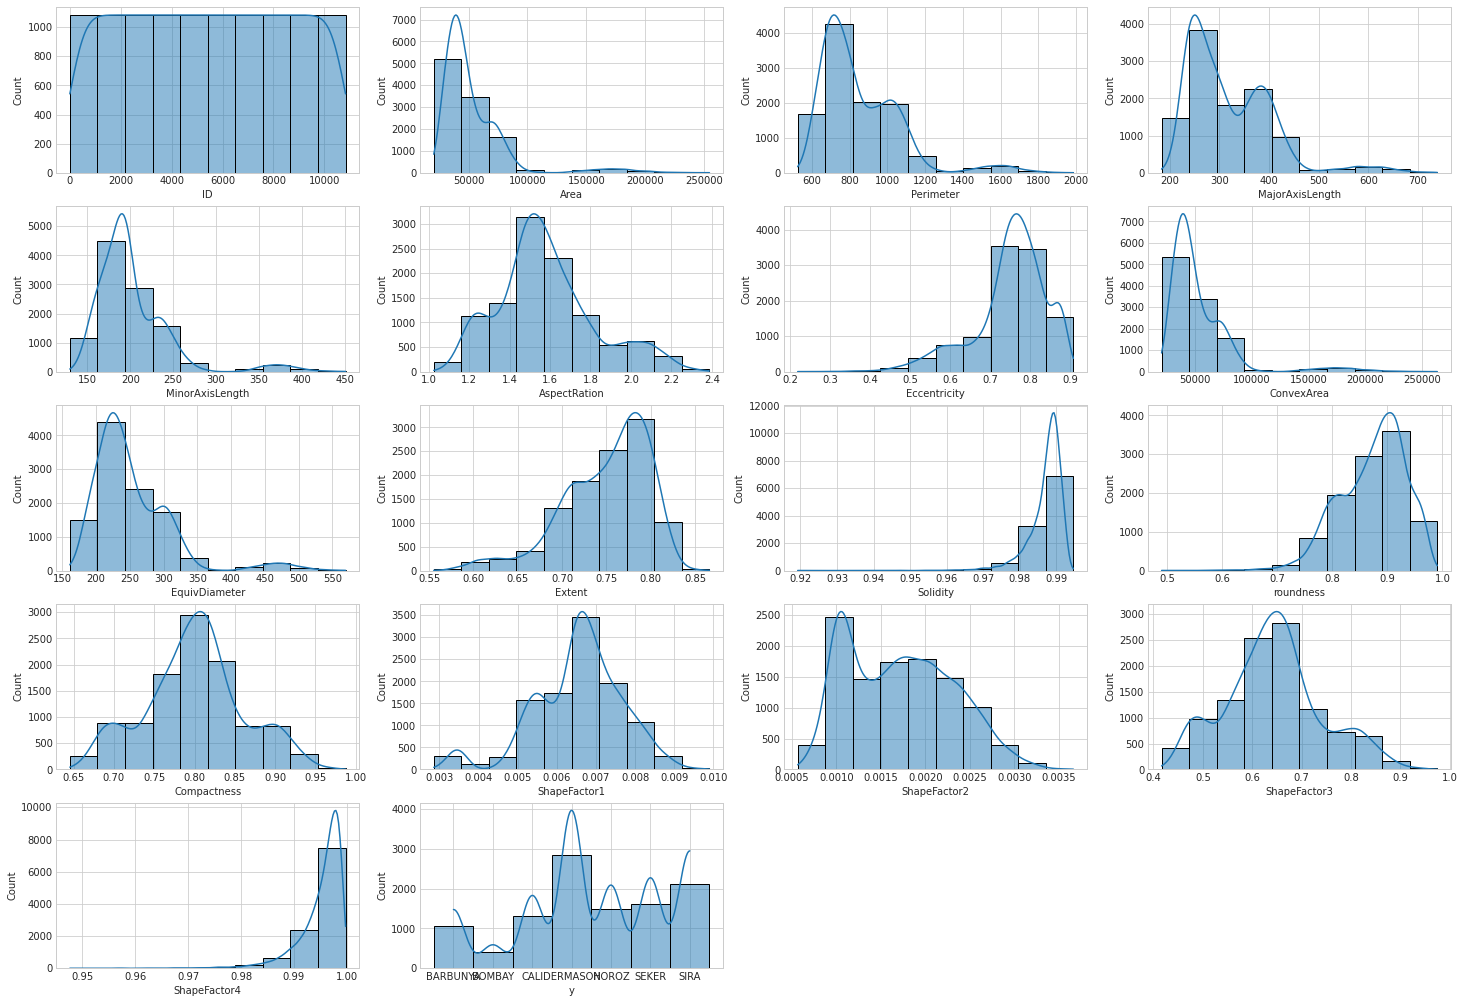

In [11]:
plt.figure(figsize=(25, 25))
for i, col in enumerate(list(raw_data.columns)):
    plt.subplot(7, 4, i+1)
    sns.histplot(raw_data[col], kde=True, bins=10)

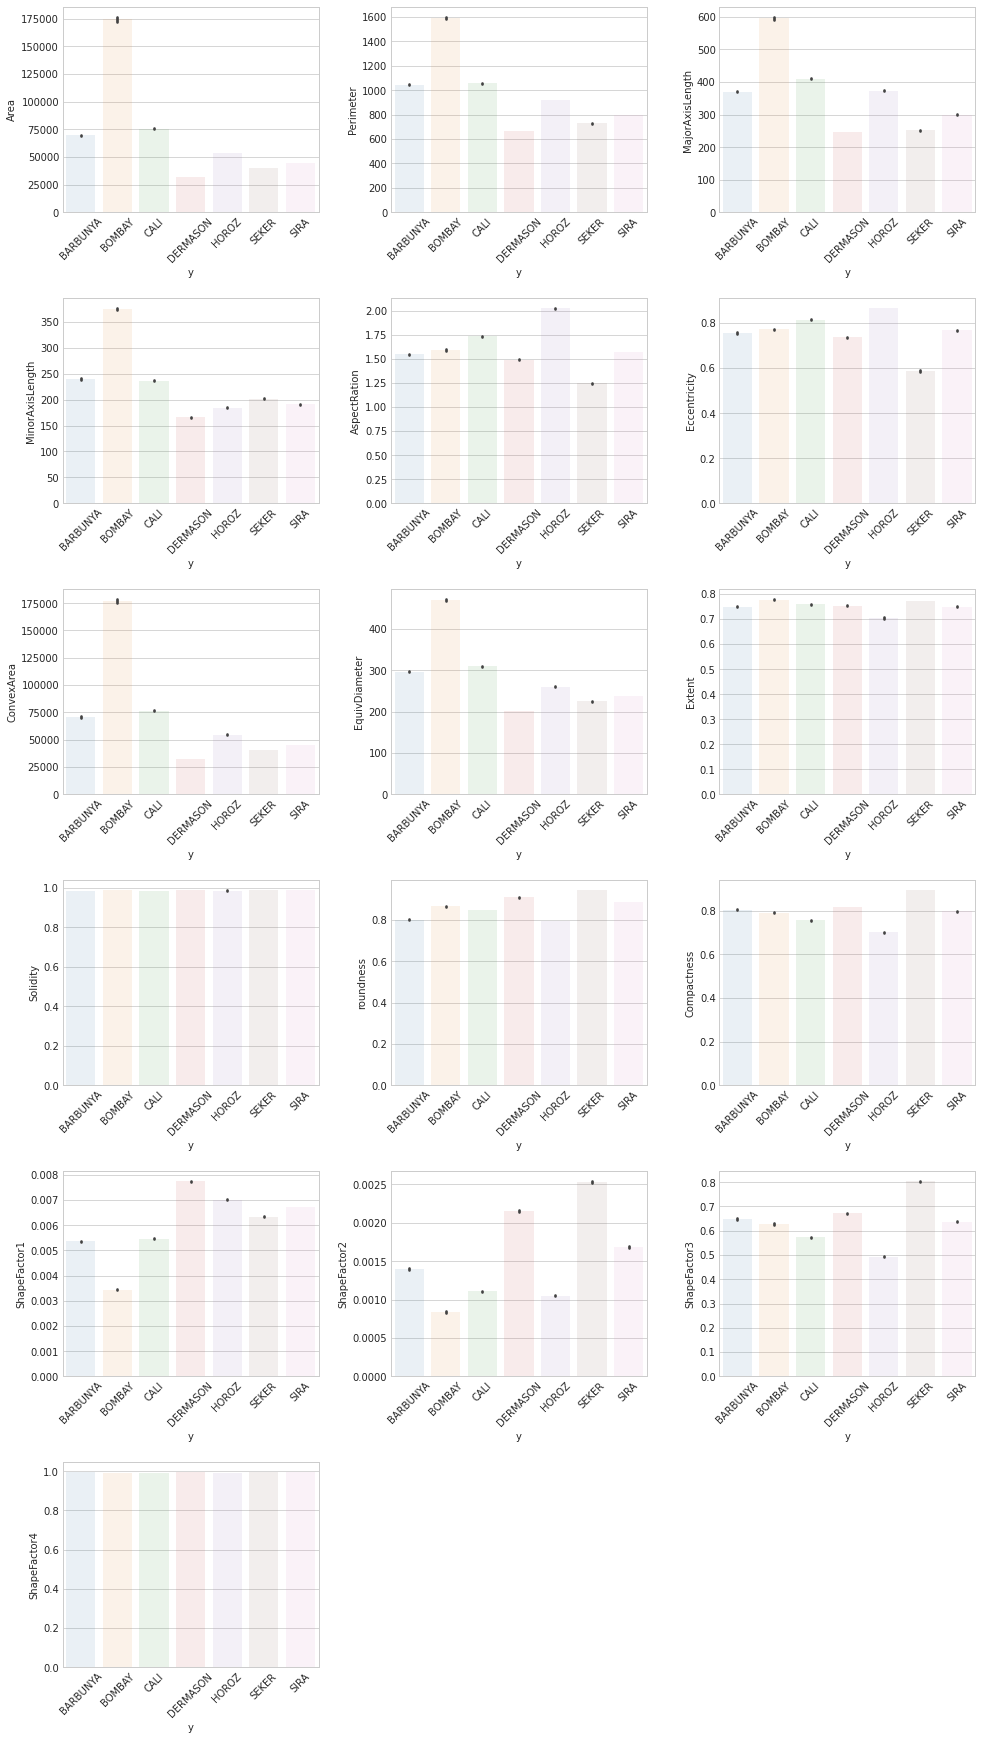

In [12]:
def plot_subplots(subplots, plot, n=3):
    m = len(subplots)
    height = (m//n + (m%n != 0)) * 4
    plt.figure(figsize=(14, height))
    for i, c in enumerate(subplots):
        plt.subplot(m//n + min(1, m%n), n, i+1)
        plot(c)
        plt.tight_layout(pad=2.0)
        plt.xticks(rotation=45)
        
num_cols = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
           'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
           'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
           'ShapeFactor3', 'ShapeFactor4']

plot_subplots(num_cols, lambda c: sns.barplot(data=raw_data, x='y', alpha=0.1, y=c))

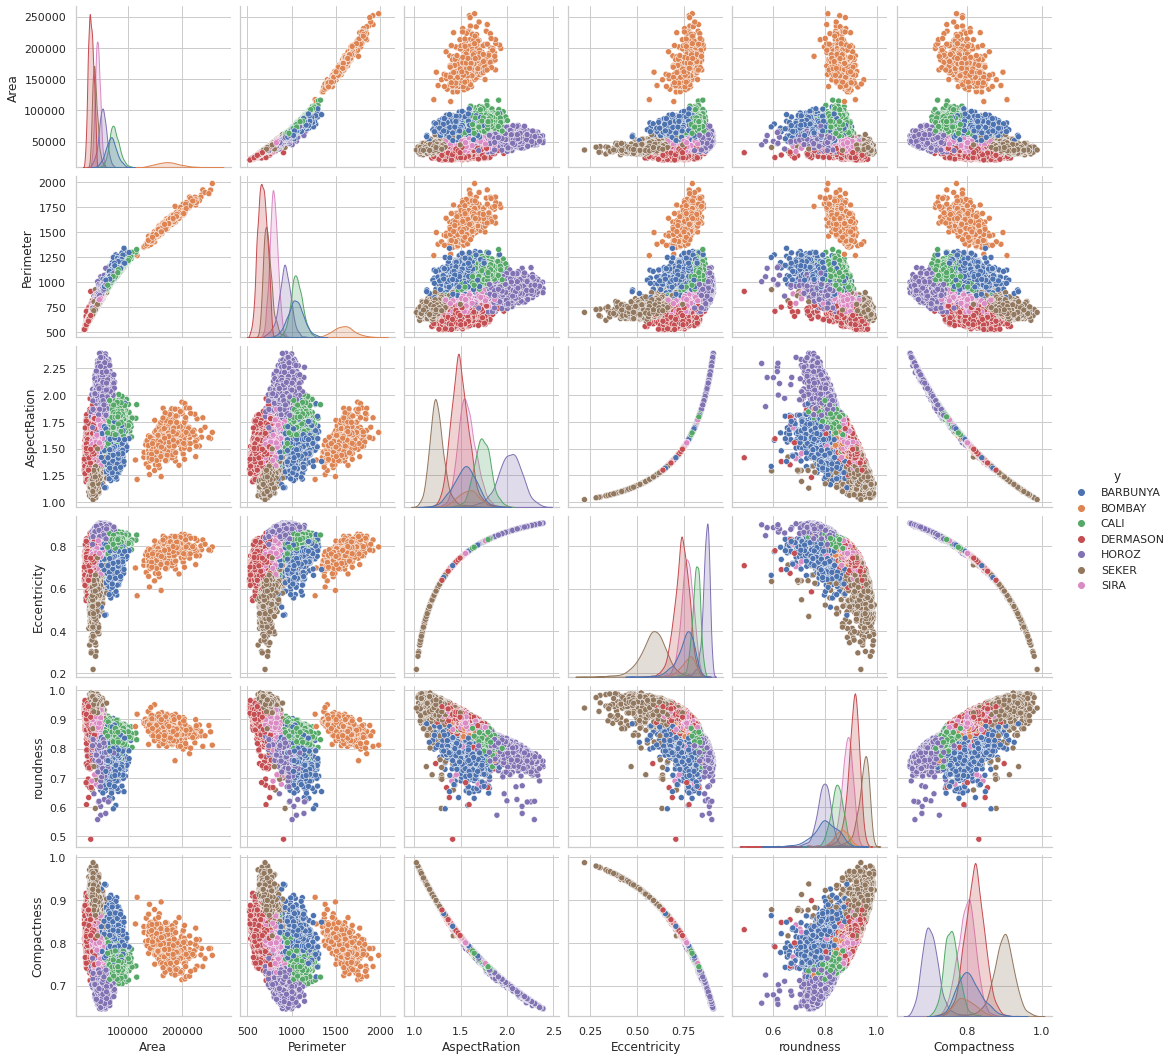

In [13]:
Strongly_corr_features = raw_data[["Area","Perimeter","AspectRation","Eccentricity","roundness","Compactness","y"]]
Strongly_corr_features.head()
sns.set_theme(style="whitegrid")
sns.pairplot(Strongly_corr_features, hue="y")

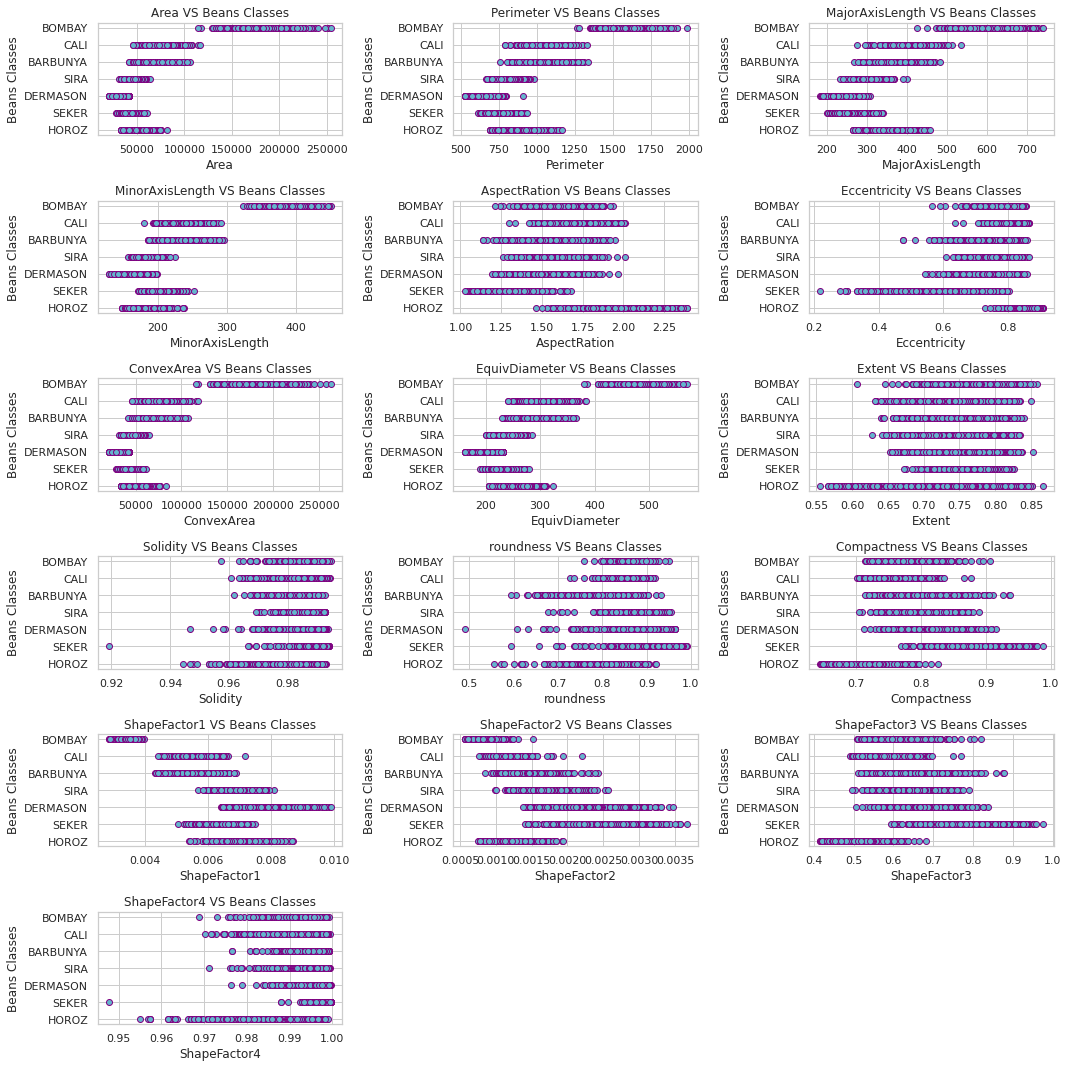

In [14]:
visualization_df=raw_data.drop(['ID'], axis=1)
i = 1
plt.figure(figsize = [15, 15], tight_layout = 5)
for column in visualization_df.drop(['y'], axis=1).columns:
    plt.subplot(6, 3, i)
    plt.scatter(data = visualization_df, x = column, y = 'y', c='c', edgecolors='purple')
    plt.xlabel(column)
    plt.ylabel('Beans Classes')
    plt.title(column + ' VS ' + 'Beans Classes')
    i += 1
plt.show()

In [15]:
raw_data.y.mode()

0    DERMASON
Name: y, dtype: category
Categories (7, object): ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']

<AxesSubplot:>

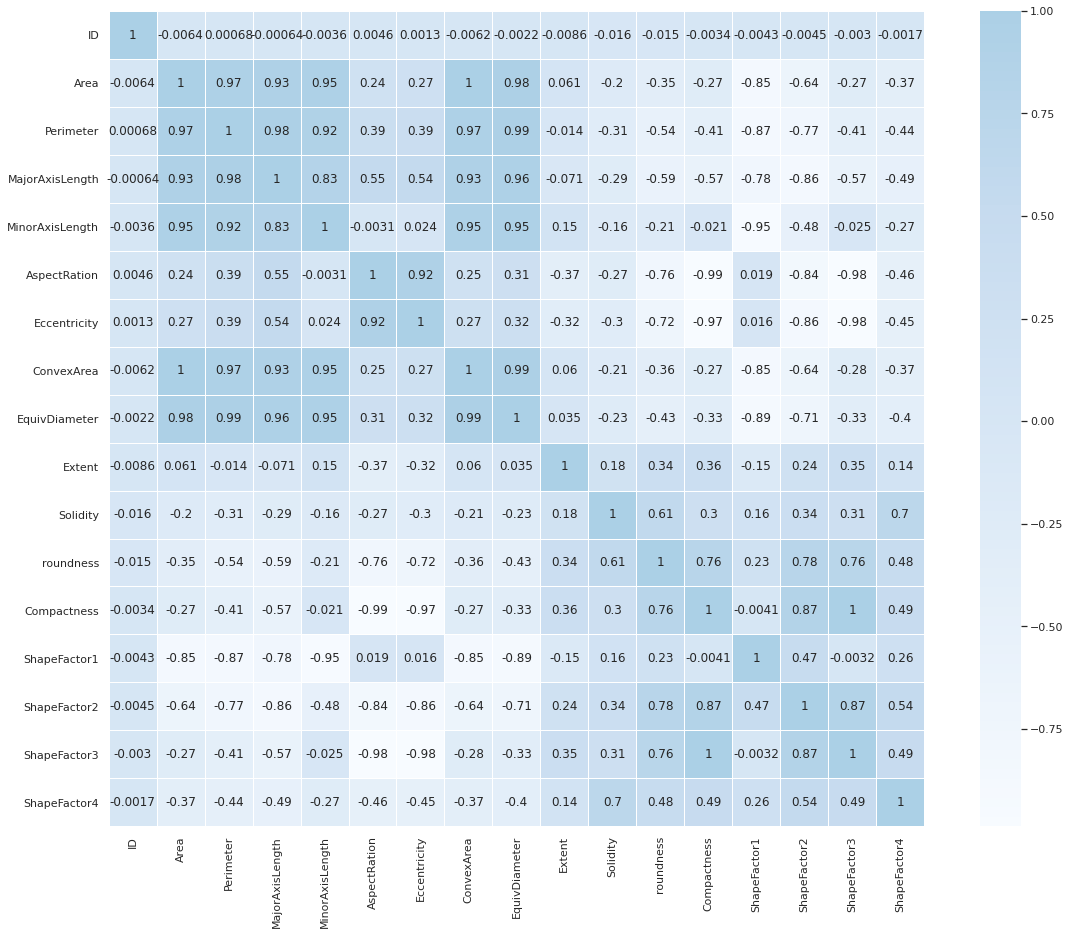

In [16]:
corr = raw_data.corr()
f,axes = plt.subplots(1,1,figsize = (20,15))
sns.heatmap(corr, square=True, annot = True, linewidth = .5, center = 2, ax = axes, cmap='Blues')

## Feature Engineering:

In [17]:
data = raw_data.copy()
data.head(10)

,ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,y
0,0,58238,971.303,397.202654,186.945510,2.124697,0.882317,58977,272.306674,0.604756,0.987470,0.775723,0.685561,0.006820,0.000929,0.469994,0.998595,HOROZ
1,1,44515,757.601,265.590470,213.967453,1.241266,0.592420,44780,238.071960,0.771745,0.994082,0.974620,0.896387,0.005966,0.002376,0.803510,0.997370,SEKER
2,2,31662,653.783,239.902428,168.421505,1.424417,0.712136,32034,200.781748,0.801407,0.988387,0.930853,0.836931,0.007577,0.002293,0.700453,0.997737,DERMASON
3,3,38778,734.020,268.446281,184.061923,1.458456,0.727925,39208,222.201897,0.766137,0.989033,0.904439,0.827733,0.006923,0.002005,0.685142,0.999250,DERMASON
4,4,42530,775.403,281.212824,193.236878,1.455275,0.726511,43028,232.703412,0.729816,0.988426,0.888895,0.827499,0.006612,0.001912,0.684755,0.996507,SIRA
5,5,34771,683.109,230.586519,192.185558,1.199812,0.552574,35163,210.408679,0.783978,0.988852,0.936369,0.912493,0.006632,0.002836,0.832644,0.999016,SEKER
6,6,45817,862.123,333.458920,175.910473,1.895617,0.849535,46654,241.528500,0.757932,0.982059,0.774637,0.724313,0.007278,0.001236,0.524629,0.994495,HOROZ
7,7,38449,746.242,284.788951,172.925734,1.646886,0.794544,38944,221.257287,0.804878,0.987289,0.867632,0.776917,0.007407,0.001665,0.603600,0.994060,SIRA
8,8,38396,709.443,250.380456,195.738890,1.279155,0.623572,38723,221.104739,0.748431,0.991555,0.958652,0.883075,0.006521,0.002446,0.779822,0.997513,SEKER
9,9,44492,785.831,297.953914,190.455857,1.564425,0.769030,44870,238.010449,0.772431,0.991576,0.905385,0.798816,0.006697,0.001682,0.638108,0.998271,SIRA


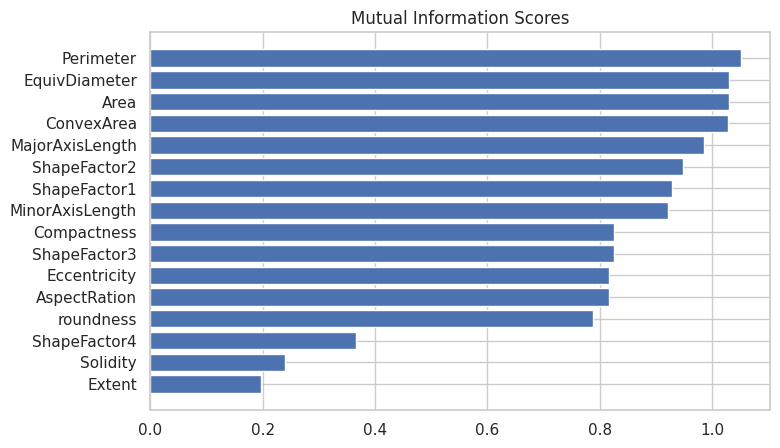

In [18]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# Label encoding for categoricals
for colname in data.select_dtypes("object"):
    data[colname], _ = data[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = data.dtypes == int

mi_scores = make_mi_scores(data.drop(columns=['ID', 'y']), data.y, discrete_features=False)
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [19]:
#Calc the skeweness of each continous feature

def calc_skew(df):
    print("\nIF THE DATA IS HIGHLY SKEWED IF SKWENESS  > 1 OR < -1 \n")
    for col in df.loc[:, df.dtypes != np.object ]:
        print("the skewness of ",col,"is :",df[col].skew())

calc_skew(data.drop(['ID','y'], axis=1))


IF THE DATA IS HIGHLY SKEWED IF SKWENESS  > 1 OR < -1 

the skewness of  Area is : 2.970246388927051
the skewness of  Perimeter is : 1.6507728935042207
the skewness of  MajorAxisLength is : 1.390286181991597
the skewness of  MinorAxisLength is : 2.2514676417086124
the skewness of  AspectRation is : 0.5891859940995571
the skewness of  Eccentricity is : -1.075626219703884
the skewness of  ConvexArea is : 2.96031471532564
the skewness of  EquivDiameter is : 1.9713782398467592
the skewness of  Extent is : -0.9008918490407785
the skewness of  Solidity is : -2.507634404049382
the skewness of  roundness is : -0.6595656889519826
the skewness of  Compactness is : 0.03824198097639841
the skewness of  ShapeFactor1 is : -0.5448725106105287
the skewness of  ShapeFactor2 is : 0.2926774098978505
the skewness of  ShapeFactor3 is : 0.2455885592440035
the skewness of  ShapeFactor4 is : -2.6285397821259355


## Data Preparation

In [20]:
def normalize_data(df,column):
    return StandardScaler().fit_transform(np.array(df[column]).reshape(-1,1))

def removeOutliers(df,outliersColomns):
    z_scores = stats. zscore(df[outliersColomns]) 
    abs_z_scores = np. abs(z_scores)
    filtered_entries = (abs_z_scores < 3). all(axis=1)
    new_df = df[filtered_entries]
    return new_df

y_labels = ['DERMASON', 'SIRA', 'SEKER', 'HOROZ', 'CALI', 'BARBUNYA', 'BOMBAY']
def removeOutliers_cat(df_raw,outliersColomns):
    df = df_raw.copy()
    for cat_ in y_labels:
        df_ = df[df['y']==cat_]
        z_scores = stats. zscore(df_[outliersColomns]) 
        abs_z_scores = np. abs(z_scores)
        filtered_entries = (abs_z_scores < 4). all(axis=1)
        df_ = df_[filtered_entries]
        df = df[df['y']!=cat_]
        df = df.append(df_)
    return df

# Transform data
def transformation(df,columns,func):
    for col in columns:
        df[col]=func(df[col])
    return df

def encodingTarget(dataset, cols):
    for col_name in cols:
        dataset[col_name] = dataset[col_name].replace({'DERMASON' :0, 'SIRA':1, 'SEKER':2, 'HOROZ':3, 'CALI':4, 'BARBUNYA':5, 'BOMBAY':6})
    return dataset

def decodingTarget(dataset, cols):
    for col_name in cols:
        dataset[col_name] = dataset[col_name].replace({0:'DERMASON' ,1: 'SIRA', 2:'SEKER', 3:'HOROZ', 4:'CALI',5: 'BARBUNYA', 6:'BOMBAY'})
    return dataset

In [21]:
data = raw_data.copy()

def prepare_data(df, isTest=False):
    
    # Creating New Features to help in prediction process.
    df['ShapeFactor5'] = df['MajorAxisLength'] / df['Perimeter']
    df['ShapeFactor6'] = df['MinorAxisLength'] / df['Perimeter']
    df['ShapeFactor7'] = df['Eccentricity'] * df['Area']
    df['ShapeFactor8'] = df['Eccentricity'] * df['Perimeter']
    df['ShapeFactor9'] = df['Extent'] * df['Area']
    df['ShapeFactor10'] = df['Extent'] * df['Perimeter']
    
    # Scaling features to equate importance.
    NonScaledFeatures=['ID', 'y','Index']
    for col_name in df.columns:
        if col_name not in NonScaledFeatures:
            scaled_col = col_name + '_r'
            df[col_name] = df[col_name].fillna(df[col_name].mean())  
            df[scaled_col]= df[col_name]
            df[col_name]=normalize_data(df,col_name)

    return df
  
data = prepare_data(data)
# labelencoder
labelencoder = LabelEncoder()
data['y'] = labelencoder.fit_transform(data['y'])
        

In [22]:
data.describe()

,ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,...,ShapeFactor1_r,ShapeFactor2_r,ShapeFactor3_r,ShapeFactor4_r,ShapeFactor5_r,ShapeFactor6_r,ShapeFactor7_r,ShapeFactor8_r,ShapeFactor9_r,ShapeFactor10_r
count,10834.000000,1.083400e+04,1.083400e+04,1.083400e+04,1.083400e+04,1.083400e+04,1.083400e+04,1.083400e+04,1.083400e+04,1.083400e+04,...,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000
mean,5416.500000,3.681956e-17,9.011724e-17,-7.157731e-16,-3.734731e-16,-9.079153e-16,-2.840015e-16,4.507911e-17,-2.331325e-16,-8.489609e-16,...,0.006559,0.001718,0.644139,0.995083,0.373014,0.239549,40578.707193,649.645637,39907.177450,641.256217
std,3127.650742,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,...,0.001127,0.000593,0.098268,0.004306,0.020664,0.024530,24332.054793,205.370394,23131.938305,169.962209
min,0.000000,-1.106106e+00,-1.536613e+00,-1.587235e+00,-1.614522e+00,-2.277615e+00,-5.811685e+00,-1.104468e+00,-1.546009e+00,-3.976247e+00,...,0.002856,0.000564,0.416499,0.947687,0.268124,0.157114,7990.845307,153.040802,15090.808731,383.970102
25%,2708.250000,-5.670788e-01,-7.055205e-01,-7.740450e-01,-5.870586e-01,-6.070721e-01,-3.753699e-01,-5.695303e-01,-6.395673e-01,-6.365942e-01,...,0.005888,0.001161,0.582747,0.993690,0.360364,0.224053,24591.865586,488.546294,27492.952148,532.777715
50%,5416.500000,-2.860642e-01,-2.862362e-01,-2.752379e-01,-2.191286e-01,-1.249823e-01,1.500480e-01,-2.889563e-01,-2.474199e-01,2.084680e-01,...,0.006643,0.001700,0.642287,0.996397,0.373675,0.240021,33566.294167,605.121243,33121.744321,588.418001
75%,8124.750000,2.775558e-01,5.593169e-01,6.518585e-01,3.303975e-01,4.982980e-01,6.434655e-01,2.811922e-01,4.415014e-01,7.545885e-01,...,0.007268,0.002169,0.695670,0.997895,0.385378,0.253749,50062.443728,801.424834,45255.396935,723.937464
max,10833.000000,6.821675e+00,5.256716e+00,4.872445e+00,5.508878e+00,3.305656e+00,1.722614e+00,6.981883e+00,5.321369e+00,2.375208e+00,...,0.009897,0.003665,0.974767,0.999733,0.428848,0.308065,202624.851901,1592.874210,200611.392105,1556.231404


In [23]:
data

,ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,...,ShapeFactor1_r,ShapeFactor2_r,ShapeFactor3_r,ShapeFactor4_r,ShapeFactor5_r,ShapeFactor6_r,ShapeFactor7_r,ShapeFactor8_r,ShapeFactor9_r,ShapeFactor10_r
0,0,0.174073,0.539713,0.897727,-0.342811,2.224308,1.440028,0.172036,0.322783,-2.966134,...,0.006820,0.000929,0.469994,0.998595,0.408938,0.192469,51384.389269,856.997346,35219.778235,587.401289
1,1,-0.290465,-0.454337,-0.633401,0.256188,-1.391835,-1.729039,-0.301224,-0.253265,0.445540,...,0.005966,0.002376,0.803510,0.997370,0.350568,0.282428,26371.578009,448.818013,34354.210659,584.674477
2,2,-0.725552,-0.937254,-0.932247,-0.753434,-0.642144,-0.420342,-0.726114,-0.880726,1.051566,...,0.007577,0.002293,0.700453,0.997737,0.366945,0.257611,22547.645337,465.582314,25374.158246,523.946475
3,3,-0.484668,-0.564026,-0.600178,-0.406731,-0.502811,-0.247737,-0.486967,-0.520301,0.330964,...,0.006923,0.002005,0.685142,0.999250,0.365721,0.250759,28227.487084,534.311725,29709.242003,562.359529
4,4,-0.357659,-0.371530,-0.451657,-0.203349,-0.515832,-0.263202,-0.359627,-0.343598,-0.411095,...,0.006612,0.001912,0.684755,0.996507,0.362667,0.249208,30898.494783,563.338480,31039.054483,565.901151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10829,10829,-0.518553,-0.647814,-0.812743,-0.215161,-1.158653,-1.233962,-0.521436,-0.568874,0.420498,...,0.006622,0.002413,0.768513,0.997708,0.349403,0.269137,24090.705139,456.603582,29107.892000,551.696917
10830,10830,-0.707781,-0.872885,-0.840616,-0.811837,-0.355019,-0.080984,-0.707846,-0.852831,-0.370439,...,0.007698,0.002116,0.667517,0.997646,0.371137,0.248325,23920.713592,496.162138,23554.622672,488.568700
10831,10831,0.972924,1.119457,1.323931,0.867104,0.879797,0.875756,0.957980,1.172360,0.450680,...,0.005301,0.001002,0.553610,0.994412,0.395861,0.220384,67981.933362,910.394028,63177.852114,846.059187
10832,10832,-0.165318,-0.134490,-0.120951,-0.069262,-0.112764,0.161455,-0.167983,-0.090236,-1.490112,...,0.006422,0.001624,0.640255,0.994793,0.374702,0.241160,36899.391686,632.461941,32639.606594,559.448490


In [24]:
data.columns

Index(['ID', 'Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'y', 'ShapeFactor5', 'ShapeFactor6',
       'ShapeFactor7', 'ShapeFactor8', 'ShapeFactor9', 'ShapeFactor10',
       'Area_r', 'Perimeter_r', 'MajorAxisLength_r', 'MinorAxisLength_r',
       'AspectRation_r', 'Eccentricity_r', 'ConvexArea_r', 'EquivDiameter_r',
       'Extent_r', 'Solidity_r', 'roundness_r', 'Compactness_r',
       'ShapeFactor1_r', 'ShapeFactor2_r', 'ShapeFactor3_r', 'ShapeFactor4_r',
       'ShapeFactor5_r', 'ShapeFactor6_r', 'ShapeFactor7_r', 'ShapeFactor8_r',
       'ShapeFactor9_r', 'ShapeFactor10_r'],
      dtype='object')

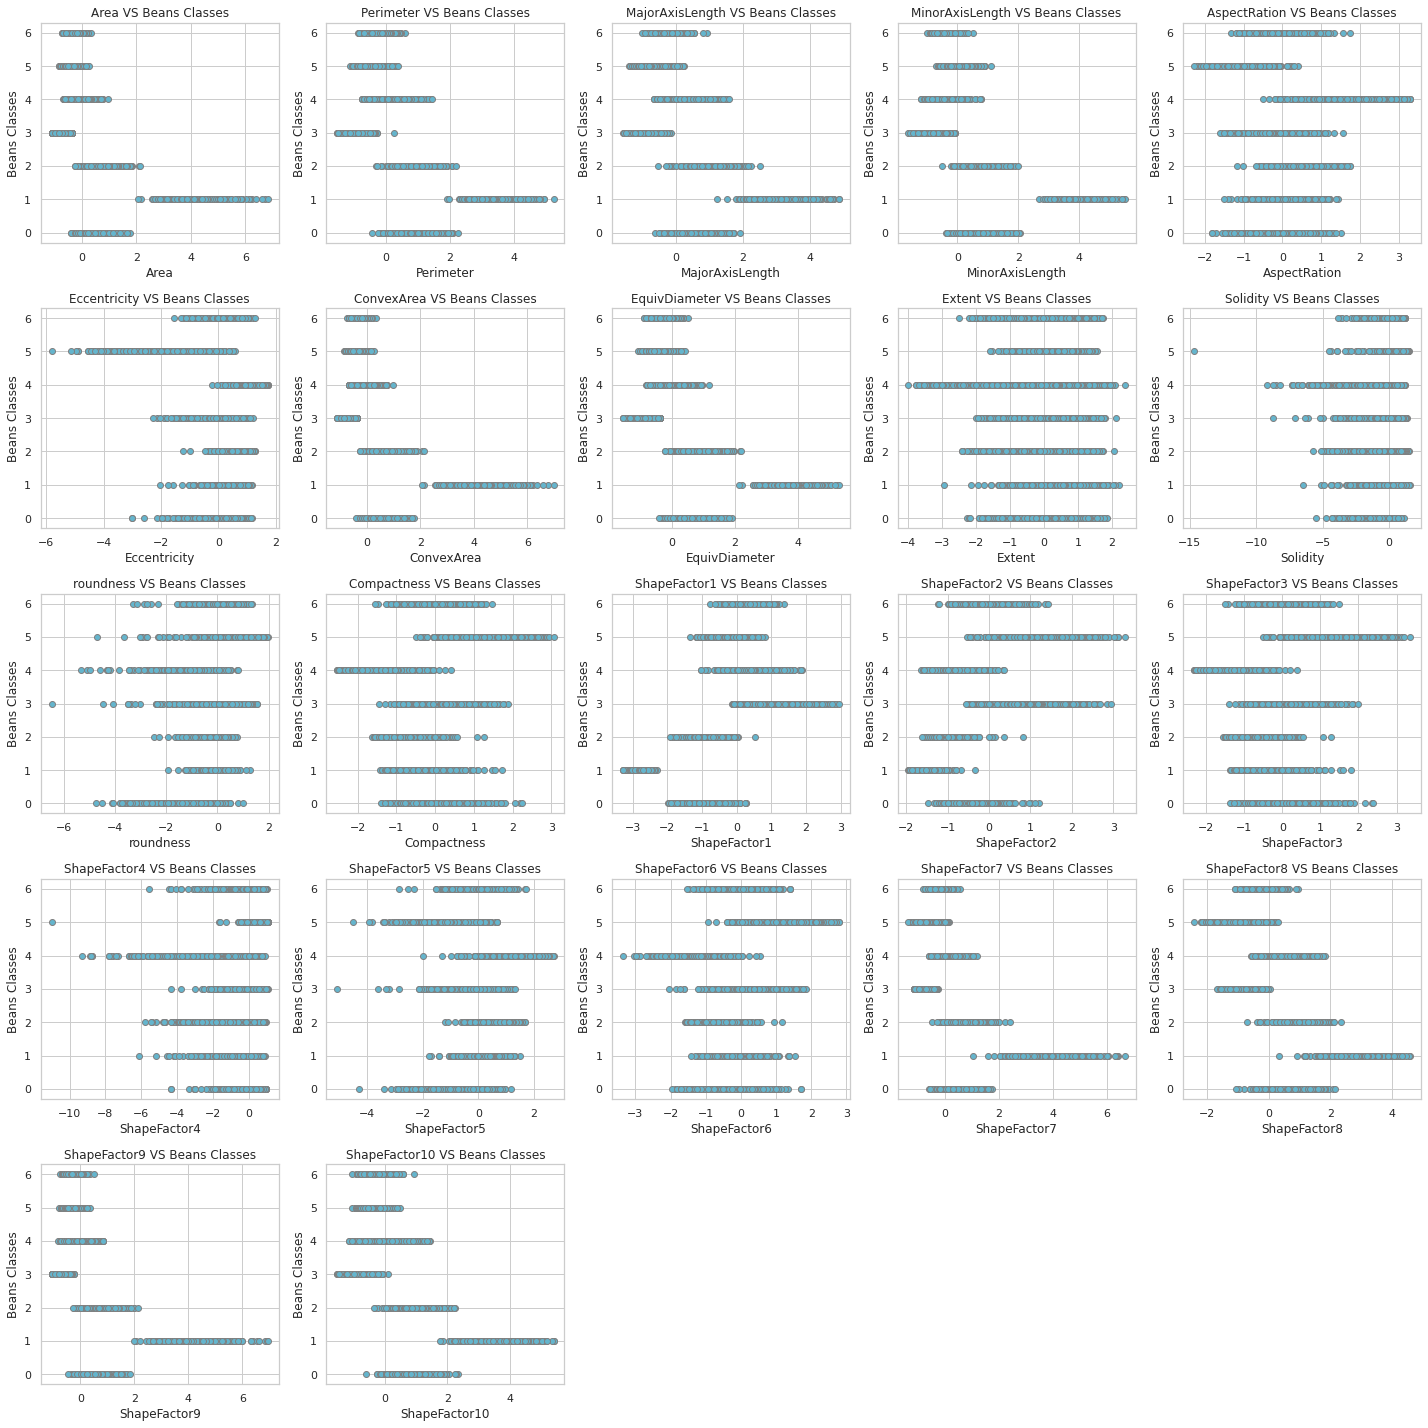

In [25]:
# print("Data after preprocessing: ")

visualization_df=data.drop(['ID','Area_r', 'Perimeter_r', 'MajorAxisLength_r', 'MinorAxisLength_r',
       'AspectRation_r', 'Eccentricity_r', 'ConvexArea_r', 'EquivDiameter_r',
       'Extent_r', 'Solidity_r', 'roundness_r', 'Compactness_r',
       'ShapeFactor1_r', 'ShapeFactor2_r', 'ShapeFactor3_r', 'ShapeFactor4_r',
       'ShapeFactor5_r', 'ShapeFactor6_r', 'ShapeFactor7_r', 'ShapeFactor8_r',
       'ShapeFactor9_r', 'ShapeFactor10_r'], axis=1)
i = 1
plt.figure(figsize = [20, 20], tight_layout = 5)
for column in visualization_df.drop(['y'], axis=1).columns:
    plt.subplot(5, 5, i)
    plt.scatter(data = visualization_df, x = column, y = 'y', c='c', edgecolors='grey')
    plt.xlabel(column)
    plt.ylabel('Beans Classes')
    plt.title(column + ' VS ' + 'Beans Classes')
    i += 1
plt.show()

## Features-labels split and train-validation split

In [26]:
train_df, val_df = train_test_split(data, test_size=0.20, random_state=42, shuffle=True, stratify=data.y) 

x_train = train_df.drop(columns=['ID','y'])
y_train = train_df['y']

x_val = val_df.drop(columns=['ID','y'])
y_val = val_df['y']

In [27]:
x_train.shape[0], x_val.shape[0]

(8667, 2167)

In [28]:
# Train with ALL DATA to increase accuracy after it has been validated.

x_train = data.drop(columns=['ID','y'])
y_train = data['y']

In [29]:
#dropped high correlated redundant features: 'ConvexArea', 'Compactness'

model_columns = [
                  'Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 
                  'AspectRation', 'Eccentricity', 'roundness', 'Extent',  'ShapeFactor5',
                  'Solidity','ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4',
                  ]

## Training different classification models on the dataset


### 1- SupportVectorClassifier:

In [30]:
svc_model = SVC(C=1.0, kernel='rbf', max_iter=-1, random_state=42, decision_function_shape='ovo', gamma=0.20)
# svc_model = SVC(C=1.0, kernel='poly', degree=3, max_iter=-1, random_state=42, decision_function_shape='ovo', gamma=0.20)
svc_model.fit(x_train[model_columns], y_train)

predictions_SVC = svc_model.predict(x_val[model_columns])
print('Mean_F1_score', f1_score(y_val, predictions_SVC, average='micro'))
print("Classification Report: \n", classification_report(y_val, predictions_SVC))

Mean_F1_score 0.9404706968158745
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       211
           1       1.00      1.00      1.00        84
           2       0.94      0.98      0.96       261
           3       0.92      0.94      0.93       567
           4       0.98      0.97      0.97       298
           5       0.97      0.95      0.96       324
           6       0.89      0.89      0.89       422

    accuracy                           0.94      2167
   macro avg       0.95      0.95      0.95      2167
weighted avg       0.94      0.94      0.94      2167



### 2- LightGB Classifier:

In [31]:
# build the lightgbm model

lgb_model = LGBMClassifier(objective='multiclass', random_state=42, learning_rate=0.03, reg_alpha=0.0001)
lgb_model.fit(x_train[model_columns], y_train)
predictions_LGB = lgb_model.predict(x_val[model_columns])

print('Mean_F1_score', f1_score(y_val, predictions_LGB, average='micro'))
print("Classification Report: \n", classification_report(y_val, predictions_LGB))

Mean_F1_score 0.9760036917397323
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       211
           1       1.00      1.00      1.00        84
           2       0.98      0.99      0.99       261
           3       0.96      0.97      0.97       567
           4       0.99      0.98      0.99       298
           5       1.00      0.98      0.99       324
           6       0.95      0.95      0.95       422

    accuracy                           0.98      2167
   macro avg       0.98      0.98      0.98      2167
weighted avg       0.98      0.98      0.98      2167



### 3- MultiLayerPerceptronClassifier:

In [32]:
# Create an instance of the MLPclassifier

mlp_model = MLPClassifier(solver='adam', activation='logistic', alpha=1e-4, random_state=42, max_iter=1000, early_stopping=True, validation_fraction=0.2, warm_start=True, verbose=False, learning_rate ='adaptive', learning_rate_init=0.01)
mlp_model = mlp_model.fit(x_train[model_columns], y_train)

predictions_MLP = mlp_model.predict(x_val[model_columns])
print('Mean_F1_score', f1_score(y_val, predictions_MLP, average='micro'))

print("Classification Report")
print(classification_report(y_val, predictions_MLP))

Mean_F1_score 0.9358560221504384
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       211
           1       1.00      1.00      1.00        84
           2       0.91      0.98      0.94       261
           3       0.91      0.95      0.93       567
           4       0.98      0.95      0.97       298
           5       0.97      0.96      0.96       324
           6       0.90      0.88      0.89       422

    accuracy                           0.94      2167
   macro avg       0.95      0.94      0.95      2167
weighted avg       0.94      0.94      0.94      2167



### 4- KNeighborsClassifier:

In [33]:
kn_model = KNeighborsClassifier(algorithm='auto', weights ='distance', n_neighbors=15)
kn_model.fit(x_train[model_columns], y_train)
          
predictions_KN = kn_model.predict(x_val[model_columns])
print('Mean_F1_score', f1_score(y_val, predictions_KN, average='micro'))
print("Classification Report: \n", classification_report(y_val, predictions_KN))

Mean_F1_score 1.0
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       211
           1       1.00      1.00      1.00        84
           2       1.00      1.00      1.00       261
           3       1.00      1.00      1.00       567
           4       1.00      1.00      1.00       298
           5       1.00      1.00      1.00       324
           6       1.00      1.00      1.00       422

    accuracy                           1.00      2167
   macro avg       1.00      1.00      1.00      2167
weighted avg       1.00      1.00      1.00      2167



Confusion Matrix:


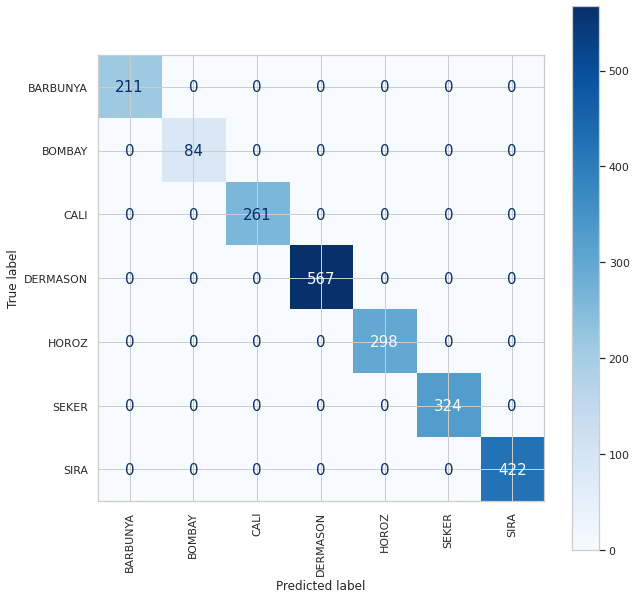

In [34]:
print("Confusion Matrix:")

y_labels = ['DERMASON', 'SIRA', 'SEKER', 'HOROZ', 'CALI', 'BARBUNYA', 'BOMBAY']
class_names= ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']
lgb = LGBMClassifier()
lgb.fit(x_train[model_columns], y_train)
np.set_printoptions(precision=5)
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(10, 10),)
plot_confusion_matrix(lgb, x_val[model_columns], y_val, display_labels=class_names, xticks_rotation='vertical', cmap=plt.cm.Blues, ax=ax)
plt.show()

### Ensemble method:

In [35]:
#voting

classifiers = [
                ('SVC:', svc_model),
                ('MLP:', mlp_model),
                ('LGB:', lgb_model),
                ('KN:', kn_model),
                ]
    
for clf_name, clf in classifiers:
#     clf.fit(x_train[model_columns], y_train)
    y_pred = clf.predict(x_val[model_columns])
    print(clf_name, f1_score(y_val, y_pred, average='micro'))

vc = VotingClassifier(estimators=classifiers)
# kfold = StratifiedKFold(n_splits=10, random_state=42)
# cv_results = cross_val_score(vc, x_train[model_columns], y_train, cv=kfold, scoring='f1_micro')
vc.fit(x_train[model_columns], y_train)
y_pred_voting = vc.predict(x_val[model_columns])
print()
print('Voting Classifier: ',f1_score(y_val, y_pred_voting, average='micro'))

SVC: 0.9404706968158745
MLP: 0.9358560221504384
LGB: 0.9760036917397323
KN: 1.0

Voting Classifier:  0.9607752653437933


## Reading the test file

In [36]:
raw_test = pd.read_csv('/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/test.csv')
raw_test.sample(10)

,ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
2369,13203,52856,915.191,380.015728,177.642170,2.139220,0.884014,53359,259.419254,0.809483,0.990573,0.793014,0.682654,0.007190,0.000963,0.466016,0.996912
108,10942,57879,968.553,401.341200,184.126468,2.179704,0.888551,58504,271.466078,0.710643,0.989317,0.775326,0.676397,0.006934,0.000895,0.457513,0.997243
1916,12750,217182,1811.572,704.304209,396.825746,1.774845,0.826164,220372,525.856169,0.675990,0.985524,0.831615,0.746632,0.003243,0.000622,0.557460,0.989404
145,10979,28960,627.343,230.568484,160.462372,1.436901,0.718098,29266,192.023481,0.765550,0.989544,0.924695,0.832826,0.007962,0.002363,0.693600,0.996634
2150,12984,52150,912.208,378.853648,175.525332,2.158399,0.886198,52747,257.680892,0.609364,0.988682,0.787547,0.680159,0.007265,0.000959,0.462617,0.998512
199,11033,52293,924.252,364.877125,191.830415,1.902082,0.850645,55421,258.033943,0.661167,0.943559,0.769259,0.707180,0.006978,0.001076,0.500104,0.951239
958,11792,39900,745.235,284.431910,179.228169,1.586982,0.776492,40298,225.393562,0.788849,0.990124,0.902810,0.792434,0.007129,0.001734,0.627952,0.996548
44,10878,41239,815.069,336.216619,157.196603,2.138829,0.883969,41825,229.144334,0.619874,0.985989,0.780062,0.681538,0.008153,0.001085,0.464494,0.993473
1160,11994,31021,645.054,238.321515,166.116680,1.434663,0.717044,31317,198.738934,0.725892,0.990548,0.936857,0.833911,0.007683,0.002292,0.695408,0.997676
2281,13115,87212,1162.062,460.814761,244.035862,1.888308,0.848263,88616,333.229301,0.784958,0.984156,0.811573,0.723131,0.005284,0.000891,0.522918,0.987430


In [37]:
raw_test.isnull().sum()

ID                 0
Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
dtype: int64

In [38]:
X_test = raw_test.copy()
X_test = prepare_data(X_test, isTest=True)

X_test = X_test.drop(columns=['ID'])

y_test_predicted_vc = vc.predict(X_test[model_columns])
y_test_predicted_vc = labelencoder.inverse_transform(y_test_predicted_vc)

raw_test['y'] = y_test_predicted_vc
# raw_test = decodingTarget(raw_test,['y'])
raw_test

,ID,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,y
0,10834,57659,955.434,387.757607,196.625782,1.972059,0.861896,60188,270.949661,0.620790,0.957982,0.793735,0.698760,0.006725,0.000989,0.488266,0.962889,HOROZ
1,10835,28772,630.362,229.990785,159.609367,1.440960,0.719993,29127,191.399185,0.767458,0.987812,0.909913,0.832204,0.007994,0.002365,0.692563,0.997956,DERMASON
2,10836,54677,911.022,308.853903,226.398571,1.364204,0.680198,55858,263.850182,0.753013,0.978857,0.827860,0.854288,0.005649,0.001856,0.729808,0.995607,BARBUNYA
3,10837,24827,578.304,214.192699,147.788172,1.449322,0.723831,25121,177.794033,0.716508,0.988297,0.932871,0.830066,0.008627,0.002526,0.689009,0.998596,DERMASON
4,10838,141850,1432.847,524.923471,346.910920,1.513136,0.750492,143680,424.981211,0.804617,0.987263,0.868240,0.809606,0.003701,0.000981,0.655462,0.991803,BOMBAY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704,13538,66833,1018.336,400.397077,214.346215,1.867992,0.844640,67787,291.709476,0.759604,0.985927,0.809876,0.728550,0.005991,0.001041,0.530786,0.991504,CALI
2705,13539,40572,725.331,250.714014,206.471935,1.214276,0.567264,40900,227.283688,0.767479,0.991980,0.969089,0.906546,0.006179,0.002574,0.821825,0.997923,SEKER
2706,13540,61226,1008.378,408.227467,199.385082,2.047432,0.872611,63901,279.204879,0.611648,0.958138,0.756657,0.683944,0.006668,0.000900,0.467780,0.957748,HOROZ
2707,13541,34238,698.847,255.829224,170.867099,1.497241,0.744255,34724,208.789788,0.724890,0.986004,0.880956,0.816130,0.007472,0.002045,0.666067,0.997263,DERMASON


In [39]:
raw_test[['ID', 'y']].to_csv('/kaggle/working/submission.csv', index=False)
